#Stacking from Scratch

In [ ]:
# Test stacking on the sonar dataset
from random import seed
from random import randrange
from csv import reader
from math import sqrt
from math import exp

# Load a CSV file
def load_csv(filename):
	dataset = list()
	with open(filename, 'r') as file:
		csv_reader = reader(file)
		for row in csv_reader:
			if not row:
				continue
			dataset.append(row)
	return dataset

# Convert string column to float
def str_column_to_float(dataset, column):
	for row in dataset:
		row[column] = float(row[column].strip())

# Convert string column to integer
def str_column_to_int(dataset, column):
	class_values = [row[column] for row in dataset]
	unique = set(class_values)
	lookup = dict()
	for i, value in enumerate(unique):
		lookup[value] = i
	for row in dataset:
		row[column] = lookup[row[column]]
	return lookup

# Split a dataset into k folds
def cross_validation_split(dataset, n_folds):
	dataset_split = list()
	dataset_copy = list(dataset)
	fold_size = int(len(dataset) / n_folds)
	for i in range(n_folds):
		fold = list()
		while len(fold) < fold_size:
			index = randrange(len(dataset_copy))
			fold.append(dataset_copy.pop(index))
		dataset_split.append(fold)
	return dataset_split

# Calculate accuracy percentage
def accuracy_metric(actual, predicted):
	correct = 0
	for i in range(len(actual)):
		if actual[i] == predicted[i]:
			correct += 1
	return correct / float(len(actual)) * 100.0

# Evaluate an algorithm using a cross validation split
def evaluate_algorithm(dataset, algorithm, n_folds, *args):
	folds = cross_validation_split(dataset, n_folds)
	scores = list()
	for fold in folds:
		train_set = list(folds)
		train_set.remove(fold)
		train_set = sum(train_set, [])
		test_set = list()
		for row in fold:
			row_copy = list(row)
			test_set.append(row_copy)
			row_copy[-1] = None
		predicted = algorithm(train_set, test_set, *args)
		actual = [row[-1] for row in fold]
		accuracy = accuracy_metric(actual, predicted)
		scores.append(accuracy)
	return scores

# Calculate the Euclidean distance between two vectors
def euclidean_distance(row1, row2):
	distance = 0.0
	for i in range(len(row1)-1):
		distance += (row1[i] - row2[i])**2
	return sqrt(distance)

# Locate neighbors for a new row
def get_neighbors(train, test_row, num_neighbors):
	distances = list()
	for train_row in train:
		dist = euclidean_distance(test_row, train_row)
		distances.append((train_row, dist))
	distances.sort(key=lambda tup: tup[1])
	neighbors = list()
	for i in range(num_neighbors):
		neighbors.append(distances[i][0])
	return neighbors

# Make a prediction with kNN
def knn_predict(model, test_row, num_neighbors=2):
	neighbors = get_neighbors(model, test_row, num_neighbors)
	output_values = [row[-1] for row in neighbors]
	prediction = max(set(output_values), key=output_values.count)
	return prediction

# Prepare the kNN model
def knn_model(train):
	return train

# Make a prediction with weights
def perceptron_predict(model, row):
	activation = model[0]
	for i in range(len(row)-1):
		activation += model[i + 1] * row[i]
	return 1.0 if activation >= 0.0 else 0.0

# Estimate Perceptron weights using stochastic gradient descent
def perceptron_model(train, l_rate=0.01, n_epoch=5000):
	weights = [0.0 for i in range(len(train[0]))]
	for epoch in range(n_epoch):
		for row in train:
			prediction = perceptron_predict(weights, row)
			error = row[-1] - prediction
			weights[0] = weights[0] + l_rate * error
			for i in range(len(row)-1):
				weights[i + 1] = weights[i + 1] + l_rate * error * row[i]
	return weights

# Make a prediction with coefficients
def logistic_regression_predict(model, row):
	yhat = model[0]
	for i in range(len(row)-1):
		yhat += model[i + 1] * row[i]
	return 1.0 / (1.0 + exp(-yhat))

# Estimate logistic regression coefficients using stochastic gradient descent
def logistic_regression_model(train, l_rate=0.01, n_epoch=5000):
	coef = [0.0 for i in range(len(train[0]))]
	for epoch in range(n_epoch):
		for row in train:
			yhat = logistic_regression_predict(coef, row)
			error = row[-1] - yhat
			coef[0] = coef[0] + l_rate * error * yhat * (1.0 - yhat)
			for i in range(len(row)-1):
				coef[i + 1] = coef[i + 1] + l_rate * error * yhat * (1.0 - yhat) * row[i]
	return coef

# Make predictions with sub-models and construct a new stacked row
def to_stacked_row(models, predict_list, row):
	stacked_row = list()
	for i in range(len(models)):
		prediction = predict_list[i](models[i], row)
		stacked_row.append(prediction)
	stacked_row.append(row[-1])
	return row[0:len(row)-1] + stacked_row

# Stacked Generalization Algorithm
def stacking(train, test):
	model_list = [knn_model, perceptron_model]
	predict_list = [knn_predict, perceptron_predict]
	models = list()
	for i in range(len(model_list)):
		model = model_list[i](train)
		models.append(model)
	stacked_dataset = list()
	for row in train:
		stacked_row = to_stacked_row(models, predict_list, row)
		stacked_dataset.append(stacked_row)
	stacked_model = logistic_regression_model(stacked_dataset)
	predictions = list()
	for row in test:
		stacked_row = to_stacked_row(models, predict_list, row)
		stacked_dataset.append(stacked_row)
		prediction = logistic_regression_predict(stacked_model, stacked_row)
		prediction = round(prediction)
		predictions.append(prediction)
	return predictions

# Test stacking on the sonar dataset
seed(1)
# load and prepare data
filename = '/content/drive/MyDrive/Colab Notebooks/implementation/Ensembles/sonar.csv'
dataset = load_csv(filename)


# convert string attributes to integers
for i in range(len(dataset[0])-1):
	str_column_to_float(dataset, i)
 

# convert class column to integers
str_column_to_int(dataset, len(dataset[0])-1)

n_folds = 3
scores = evaluate_algorithm(dataset, stacking, n_folds)

print('Scores: %s' % scores)
print('Mean Accuracy: %.3f%%' % (sum(scores)/float(len(scores))))

Scores: [78.26086956521739, 76.81159420289855, 69.56521739130434]
Mean Accuracy: 74.879%


#Stacking for Classification


##Without Stacking

>lr 0.866 (0.029)
>knn 0.931 (0.025)
>cart 0.824 (0.045)
>svm 0.957 (0.020)
>bayes 0.833 (0.031)


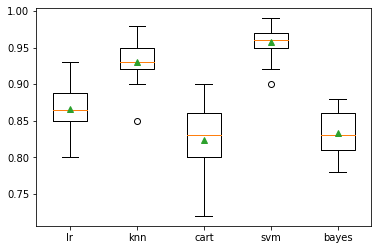

In [ ]:
# compare standalone models for binary classification
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from matplotlib import pyplot

# get the dataset
def get_dataset():
	X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=1)
	return X, y

# get a list of models to evaluate
def get_models():
	models = dict()
	models['lr'] = LogisticRegression()
	models['knn'] = KNeighborsClassifier()
	models['cart'] = DecisionTreeClassifier()
	models['svm'] = SVC()
	models['bayes'] = GaussianNB()
	return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
	return scores

# define dataset
X, y = get_dataset()
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

##With Stacking

>lr 0.866 (0.029)
>knn 0.931 (0.025)
>cart 0.822 (0.045)
>svm 0.957 (0.020)
>bayes 0.833 (0.031)
>stacking 0.962 (0.020)


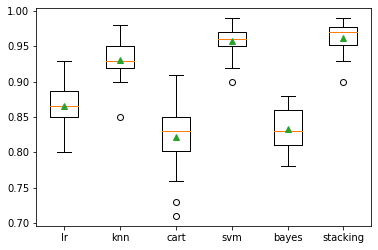

In [ ]:
# compare ensemble to each baseline classifier
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import StackingClassifier
from matplotlib import pyplot

# get the dataset
def get_dataset():
	X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=1)
	return X, y

# get a stacking ensemble of models
def get_stacking():
	# define the base models
	level0 = list()
	level0.append(('lr', LogisticRegression()))
	level0.append(('knn', KNeighborsClassifier()))
	level0.append(('cart', DecisionTreeClassifier()))
	level0.append(('svm', SVC()))
	level0.append(('bayes', GaussianNB()))
	# define meta learner model
	level1 = LogisticRegression()
	# define the stacking ensemble

  #StackingClassifier model by first defining a list of tuples for the five base models, 
  #then defining the logistic regression meta-model to combine the predictions from 
  #the base models using 5-fold cross-validation.
	model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
	return model

# get a list of models to evaluate
def get_models():
	models = dict()
	models['lr'] = LogisticRegression()
	models['knn'] = KNeighborsClassifier()
	models['cart'] = DecisionTreeClassifier()
	models['svm'] = SVC()
	models['bayes'] = GaussianNB()
	models['stacking'] = get_stacking()
	return models

# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
	return scores

# define dataset
X, y = get_dataset()
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

##Prediction

In [ ]:
# make a prediction with a stacking ensemble
from sklearn.datasets import make_classification
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
# define dataset
X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=1)
# define the base models
level0 = list()
level0.append(('lr', LogisticRegression()))
level0.append(('knn', KNeighborsClassifier()))
level0.append(('cart', DecisionTreeClassifier()))
level0.append(('svm', SVC()))
level0.append(('bayes', GaussianNB()))
# define meta learner model
level1 = LogisticRegression()
# define the stacking ensemble
model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
# fit the model on all available data
model.fit(X, y)
# make a prediction for one example
data = [[2.47475454,0.40165523,1.68081787,2.88940715,0.91704519,-3.07950644,4.39961206,0.72464273,-4.86563631,-6.06338084,-1.22209949,-0.4699618,1.01222748,-0.6899355,-0.53000581,6.86966784,-3.27211075,-6.59044146,-2.21290585,-3.139579]]
yhat = model.predict(data)
print('Predicted Class: %d' % (yhat))

Predicted Class: 0


#Stacking for Regression

##Without Stacking

>knn -101.019 (7.161)
>cart -147.406 (11.609)
>svm -162.419 (12.565)


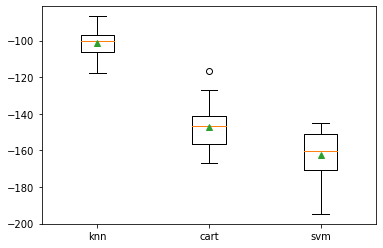

In [ ]:
# compare machine learning models for regression
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from matplotlib import pyplot

# get the dataset
def get_dataset():
	X, y = make_regression(n_samples=1000, n_features=20, n_informative=15, noise=0.1, random_state=1)
	return X, y

# get a list of models to evaluate
def get_models():
	models = dict()
	models['knn'] = KNeighborsRegressor()
	models['cart'] = DecisionTreeRegressor()
	models['svm'] = SVR()
	return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
	cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
	return scores

# define dataset
X, y = get_dataset()
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

##With Stacking

>knn -101.019 (7.161)
>cart -147.523 (10.375)
>svm -162.419 (12.565)
>stacking -56.413 (5.200)


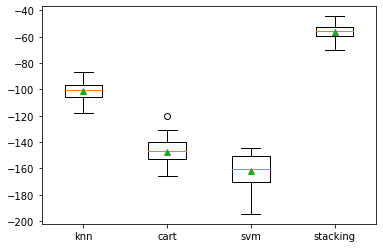

In [ ]:
# compare ensemble to each standalone models for regression
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import StackingRegressor
from matplotlib import pyplot

# get the dataset
def get_dataset():
	X, y = make_regression(n_samples=1000, n_features=20, n_informative=15, noise=0.1, random_state=1)
	return X, y

# get a stacking ensemble of models
def get_stacking():
	# define the base models
	level0 = list()
	level0.append(('knn', KNeighborsRegressor()))
	level0.append(('cart', DecisionTreeRegressor()))
	level0.append(('svm', SVR()))
	# define meta learner model
	level1 = LinearRegression()
	# define the stacking ensemble
	model = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)
	return model

# get a list of models to evaluate
def get_models():
	models = dict()
	models['knn'] = KNeighborsRegressor()
	models['cart'] = DecisionTreeRegressor()
	models['svm'] = SVR()
	models['stacking'] = get_stacking()
	return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
	cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
	return scores

# define dataset
X, y = get_dataset()
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

In [ ]:
# make a prediction with a stacking ensemble
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import StackingRegressor
# define dataset
X, y = make_regression(n_samples=1000, n_features=20, n_informative=15, noise=0.1, random_state=1)
# define the base models
level0 = list()
level0.append(('knn', KNeighborsRegressor()))
level0.append(('cart', DecisionTreeRegressor()))
level0.append(('svm', SVR()))
# define meta learner model
level1 = LinearRegression()
# define the stacking ensemble
model = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)
# fit the model on all available data
model.fit(X, y)
# make a prediction for one example
data = [[0.59332206,-0.56637507,1.34808718,-0.57054047,-0.72480487,1.05648449,0.77744852,0.07361796,0.88398267,2.02843157,1.01902732,0.11227799,0.94218853,0.26741783,0.91458143,-0.72759572,1.08842814,-0.61450942,-0.69387293,1.69169009]]
yhat = model.predict(data)
print('Predicted Value: %.3f' % (yhat))

Predicted Value: 555.270
